# Morph average PILRs into mean shape

In [1]:
!date

Tue Mar 19 13:23:02 PDT 2024


In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt

from cellpack_analysis.utilities import common
from pathlib import Path

from cellpack_analysis.utilities.mesh_tools import get_average_shape_mesh_objects
from aicscytoparam import cytoparam

### Compute voxelization of mean shape

In [3]:
# TODO: move this path to a config file
mesh_folder = "/allen/aics/animated-cell/Saurabh/cellpack-analysis/data/average_shape_meshes"
mesh_dict = get_average_shape_mesh_objects(mesh_folder)
outer_mesh = mesh_dict["mem"]
inner_mesh = mesh_dict["nuc"]

In [13]:
domain, domain_nuc, domain_mem, coords_param = common.get_mean_shape_as_image(
    outer_mesh=outer_mesh, inner_mesh=inner_mesh
)

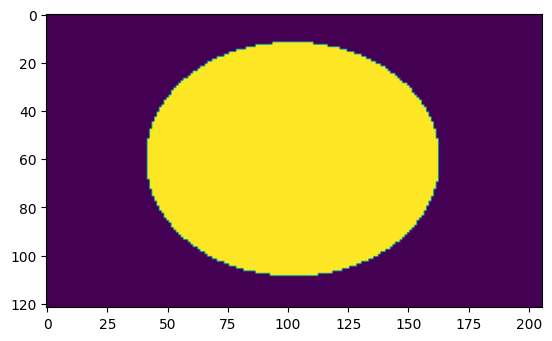

In [30]:
from matplotlib.pyplot import imshow

img = domain_nuc
imshow(img[:,img.shape[1]//2,:])

### Load computed average PILRs

In [21]:
STRUCTURE_ID = "SLC25A17"
STRUCTURE_NAME = "peroxisome"
FOLDER_ID = "RS"

In [22]:
base_folder = Path(f"/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/{STRUCTURE_ID}/{FOLDER_ID}/")

In [23]:
with open(base_folder / "avg_PILR.json", "r") as f:
    avg_pilr = json.load(f)

avg_pilr = {
    k: np.expand_dims(np.array(v), 0)
    for k, v in avg_pilr.items()
}
print(avg_pilr.keys())

dict_keys(['SLC25A17', 'random', 'nucleus_moderate', 'membrane_moderate'])


### Morph average PILRs

In [24]:
figdir = base_folder / "morphed_average_pilrs"
figdir.mkdir(exist_ok=True)

In [25]:
plt.rcdefaults()

Image shape: (300, 300, 300), slices used: (149,145,149)
Image shape: (300, 300, 300), slices used: (149,145,149)
Image shape: (300, 300, 300), slices used: (149,145,149)
vmin/vmax values already set...


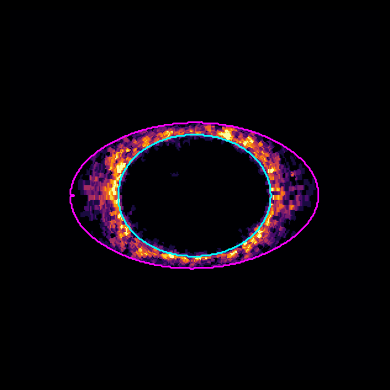

Image shape: (300, 300, 300), slices used: (149,145,149)
Image shape: (300, 300, 300), slices used: (149,145,149)
Image shape: (300, 300, 300), slices used: (149,145,149)
vmin/vmax values already set...


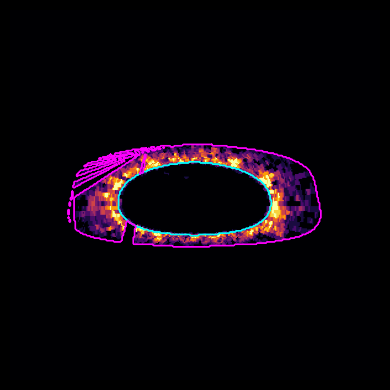

In [32]:
for ch, pilr in avg_pilr.items():
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=pilr,
    )
    data = np.stack([domain_nuc, domain_mem, morphed], axis=0)
    mode = {"nuc": "center_nuc", "mem": "center_nuc", "gfp": "center_nuc"}
    if "nucleus" in ch:
        vmin = np.percentile(pilr, 1)
        vmax = np.percentile(pilr, 99)
    else:
        continue
        vmin = 0
        vmax = np.percentile(pilr, 99)
    projector = common.Projector(data, mask_on=True, box_size=300, force_fit=True)
    projector.set_vmin_vmax_gfp_values(vmin, vmax)
    projector.set_panel_size(4)
    for proj, dim in enumerate(["y", "z"]):
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), facecolor="black")
        projector.set_projection_mode(ax=dim, mode=mode)
        projector.compute()
        contour = projector.get_proj_contours()
        projector.view(alias="gfp", ax=ax)
        for alias_cont, alias_color in zip(["nuc", "mem"], ["cyan", "magenta"]):
            [
                ax.plot(c[:, 1], c[:, 0], lw=1, color=alias_color)
                for c in contour[alias_cont]
            ]
            [
                ax.plot(c[:, 1], c[:, 0], lw=1, color=alias_color)
                for c in contour[alias_cont]
            ]
        # ax.set_title(f"{ch} {dim}")
        ax.axis("off")
        plt.tight_layout()
        fig.savefig(figdir / f"{ch}_{dim}.png")
        plt.show()
        # break
    # break